## Pairs Trading Strategy

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import math
import pylab
import seaborn as sb; sb.set(style="whitegrid")
import datetime as dt
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

yf.pdr_override()
pd.core.common.is_list_like = pd.api.types.is_list_like
pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'

### Stationarity/Non-Stationarity

Stationarity is the most commonly untestedassumption in time series analysis. We generally assume that data is stationary when the parameters of the data generating process do not change over time. Else consider two series: A and B. Series A will generate a stationary time series with fixed parameters, while B will change over time.

We will create a function that creates a z-score for probability density function. The probability density for a Gaussian distribution is:

$$ p(x) = \frac{1}{\sqrt{2\pi\sigma^{2}}}e^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}$$


$\mu$ is the mean and $\sigma$ is the standard deviation. The square of the standard deviation, $\sigma^{2}$, is the variance. The empirical rule dictates that 66% of the data should be somewhere between $x+\sigma$ and $x-\sigma$, which iplies that the function `numpy.random.normal` is more likely to return samples lying close to the mean, rather than those far away.

In [2]:
def generate_data(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu,sigma)

Text(0.5, 1.0, "['Non-Stationary']")

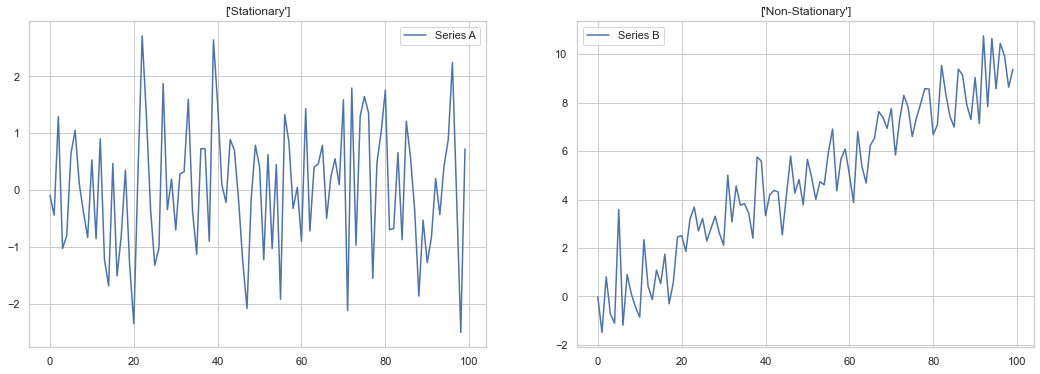

In [3]:
# Setting the parameters and the number of datapoints
params = (0,1)
T = 100

A = pd.Series(index=range(T), dtype='float64')
A.name = 'A'

for t in range(T):
    A[t] = generate_data(params)
    
T = 100
B = pd.Series(index=range(T), dtype='float64')
B.name = 'B'

for t in range(T):
    # this set of data will be dependent on time i.e. the mean of the series changes over time
    params = (t*0.1, 1)
    B[t] = generate_data(params)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ax1.plot(A)
ax2.plot(B)
ax1.legend(['Series A'])
ax2.legend(['Series B'])
ax1.set_title(['Stationary'])
ax2.set_title(['Non-Stationary'])

### Why Stationarity is Important
Many statistical tests require that the data being tested are stationary. Using certain statistics on a non-stationary dataset may lead to garbage results. As an example, let's take an average through non-stationary B.

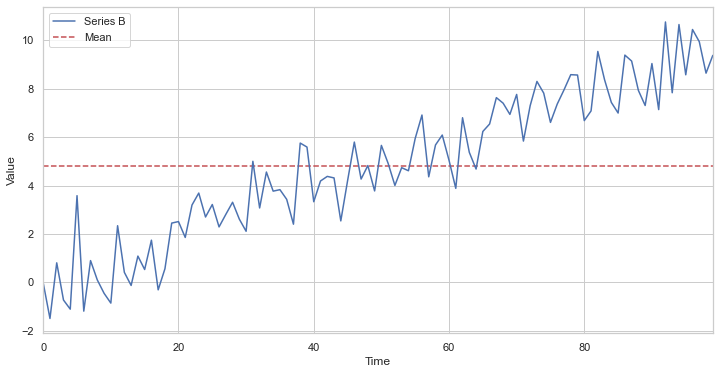

In [4]:
meanB = np.mean(B)

plt.figure(figsize=(12,6))
plt.plot(B)
plt.hlines(meanB,0,len(B),colors='r',linestyles='dashed')
plt.xlabel('Time')
plt.xlim([0,99])
plt.ylabel('Value')
plt.legend(['Series B', 'Mean'])

The computed mean will show that the mean of all data points, but won't be useful for any forecasting of future state. It's meaningless when compared with any specific time, as it's a collection of different states at different times mashed together. This is just a simple and clear example of why non-stationarity can distort the analysis, much more subtle problems can arise in practice.

#### Augmented Dickey Fuller

In order to test for stationarity, we need to test for something called a *unit root*. Autoregressive unit root test are based the following hypothesis test:

$$
\begin{aligned}
H_{0} & : \phi =\ 1\ \implies y_{t} \sim I(0) \ | \ (unit \ root) \\
H_{1} & : |\phi| <\ 1\ \implies y_{t} \sim I(0) \ | \ (stationary)  \\
\end{aligned}
$$

It's referred to as a unit root tet because under the null hypothesis, the autoregressive polynominal of $\scr{z}_{t},\ \phi (\scr{z})=\ (1-\phi \scr{z}) \ = 0$, has a root equal to unity. 

$y_{t}$ is trend stationary under the null hypothesis. If $y_{t}$is then first differenced, it becomes:

$$
\begin{aligned}
\Delta y_{t} & = \delta\ + \Delta\scr{z}_{t} \\
\Delta \scr_{z} & = \phi\Delta\scr{z}_{t-1}\ +\ \varepsilon_{t}\ -\ \varepsilon_{t-1} \\
\end{aligned}
.$$

The test statistic is

$$ t_{\phi=1}=\frac{\hat{\phi}-1}{SE(\hat{\phi})}$$

$\hat{\phi}$ is the least square estimate and SE($\hat{\phi}$) is the usual standard error estimate. The test is a one-sided left tail test. If {$y_{t}$} is stationary, then it can be shown that

$$\sqrt{T}(\hat{\phi}-\phi)\xrightarrow[\text{}]{\text{d}}N(0,(1-\phi^{2}))$$

or 

$$\hat{\phi}\overset{\text{A}}{\sim}N\bigg(\phi,\frac{1}{T}(1-\phi^{2}) \bigg)$$

andit follows that $t_{\phi=1}\overset{\text{A}}{\sim}N(0,1).$ However, under the null hypothesis of non-stationarity, the above result gives

$$
\hat{\phi}\overset{\text{A}}{\sim} N(0,1)
$$

The following function will allow us to check for stationarity using the Augmented Dickey Fuller (ADF) test.

In [5]:
def ADF_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name + ' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name + ' is likely NON-stationary.')

In [6]:
ADF_test(A)
ADF_test(B)

p-value = 5.776023030458818e-18 The series A is likely stationary.
p-value = 0.7450970209617143 The series B is likely NON-stationary.


As we can see, based on the ADF test (which corresponds with a specific p-value) for time series A, we can fail to reject the null hypothesis. As such, Series A is likely to be stationary. On the otherhand, Series B is rejected by the hypothesis test, so this time series is likely to be NON-stationary

### Cointegration
The correlations between financial quantities are notoriously unstable. Nevertheless, correlations are regularly used in almost all multivariate financial problems. An alternative statistical measure to correlation is cointegration. This is probably a more robust measure of linkage between two financial quantities, but as yet there is little derivatives theory on this concept

Two stocks may be perfectly correlated over short timescales, yet diverge in the long run, with one growing and the other decaying and vice versa. Conversely, two stocks may follow each other, never being more than a certain distance apart, but with any correlation, positive , negative or varying. If we are delta hedging, then maybe the short timescale correlation matters, but not if we are holding stocks for a long time in unhedged portfolio



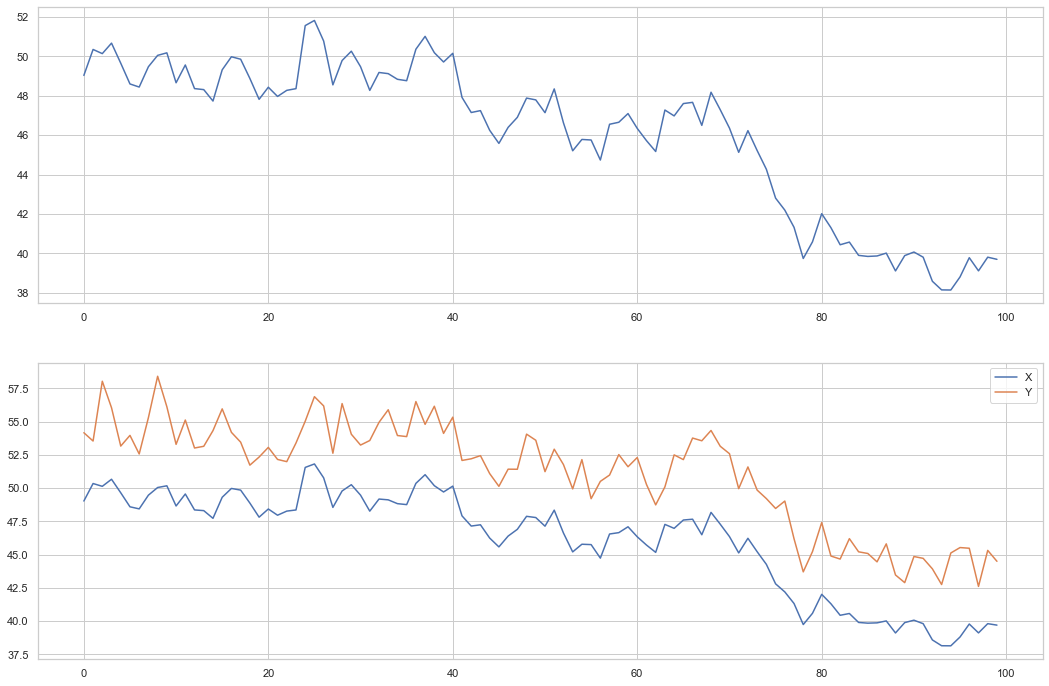

In [7]:
# Generate daily returns
Xreturns = np.random.normal(0,1,100)

# Sum up and shift prices up
X = pd.Series(np.cumsum(Xreturns), name='X') + 50

noise = np.random.normal(0,1,100)
Y = X + 5 + noise
Y.name = 'Y'

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,12))
XY = pd.concat([X,Y], axis=1)

ax1.plot(X)
ax2.plot(XY)
plt.legend(['X', 'Y'])

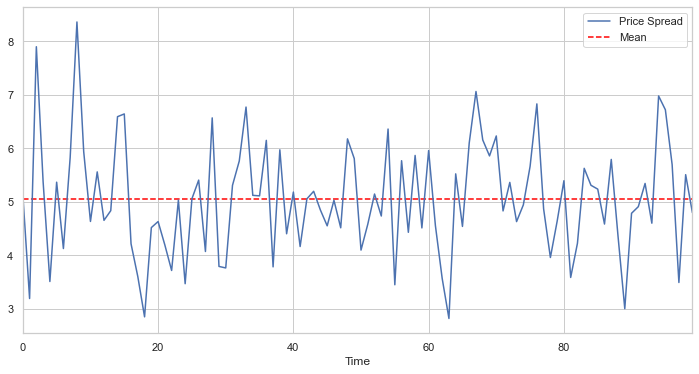

In [8]:
spread = Y-X

plt.figure(figsize=(12,6))
plt.plot(spread) # Y-X gives the spread
plt.hlines((Y-X).mean(), 0, len(Y-X), colors='red', linestyle='dashed') # Add the mean
plt.xlabel("Time")
plt.xlim(0,99)
plt.legend(['Price Spread', 'Mean'])

#### Testing for Cointegration

The steps in the cointegration test procdure:

1. Test for a unit root in each component series $y_{t}$ individually, using the univariate unit root tests, say ADF, Phillips-Perron test.
2. If the unit root cannot be rejected, then the next step is to test cointegration among the components, i.e., to test whether $\alpha Y_{t}$ is I(0).

If we find that the time series as a unit root, then we move on to the cointegration process. There are three main methods for testing for cointegration: Johansen, Engle-Granger, and Phillips-Ouliaris. We will primarily use the Engle-Granger test.

Let's consider the regression model for $y_{t}$:

$$y_{1t} = \delta D_{t} + \phi_{1t}y_{2t} + \phi_{m-1} y_{mt} + \varepsilon_{t} $$

$D_{t}$ is the deterministic term. From there, we can test whether $\varepsilon_{t}$ is $I(1)$ or $I(0)$. The hypothesis test is as follows:

$$
\begin{aligned}
H_{0} & :  \varepsilon_{t} \sim I(1) \implies y_{t} \ (no \ cointegration)  \\
H_{1} & : \varepsilon_{t} \sim I(0) \implies y_{t} \ (cointegration)  \\
\end{aligned}
$$

$y_{t}$ is cointegrated with a *normalized cointegration vector* $\alpha = (1, \phi_{1}, \ldots,\phi_{m-1}).$

We also use residuals $\varepsilon_{t}$ for unit root test.

$$
\begin{aligned}
H_{0} & :  \lambda = 0 \ (Unit \ Root)  \\
H_{1} & : \lambda < 1 \ (Stationary)  \\
\end{aligned}
$$

This hypothesis test is for the model:

$$\Delta\varepsilon_{t}=\lambda\varepsilon_{t-1}+\sum^{p-1}_{j=1}\varphi\Delta\varepsilon_{t-j}+\alpha_{t}$$

The test statistic for the following equation:

$$t_{\lambda}=\frac{\hat{\lambda}}{s_{\hat{\lambda}}} $$

Now that you understand what it means for two time series to be cointegrated, we can test for it and measure it using python:

In [9]:
score, pvalue, _ = coint(X,Y) # Low p-value = High Cointegration!

print(pvalue)

8.112252914093443e-13


### Correlation vs Cointegration
Correlation and cointegration, while theoretically similar, are anything BUT similar. To demonstrate this, let's look at the examples of two time series that are correlated but not cointegrated.

A simple example is two time series that just diverge.

(0.0, 99.0)

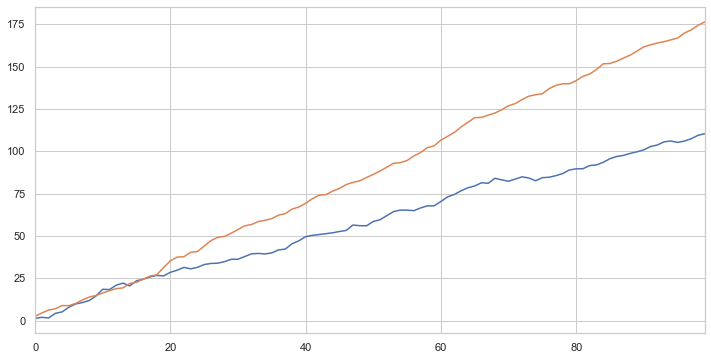

In [10]:
X_returns = np.random.normal(1,1,100)
Y_returns = np.random.normal(2,1,100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')

XY = pd.concat([X_diverging, Y_diverging], axis=1)
plt.figure(figsize=(12,6))
plt.plot(XY)
plt.xlim(0,99)

Next, we will print the correlation coefficient, r, and the cointegration test

In [11]:
print('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue,_ = coint(X_diverging, Y_diverging)
print('Cointegration p-value: ', str(pvalue))

Correlation: 0.9967961916071535
Cointegration p-value:  0.0070961917014647395


As observed, there is a very strong correlation between series X and Y but our p-value for our cointegration test yield a result of 0.9764, which means that there is no cointegration between the time series X and Y.

Another example is a normally distributed time series and a square wave.

Correlation: -0.0672002216620611
Cointegration p-value:  0.0


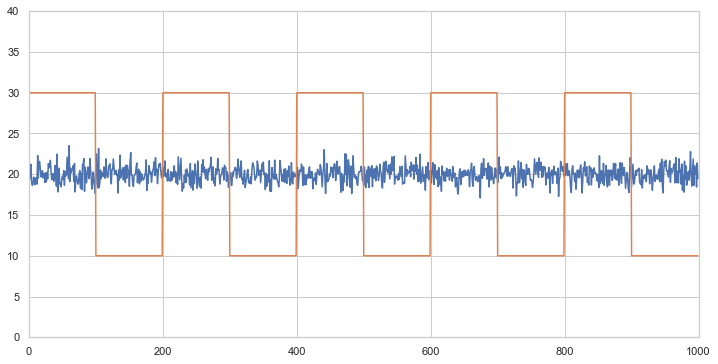

In [12]:
Y2 = pd.Series(np.random.normal(0,1,1000), name='Y2') + 20
Y3 = Y2.copy()

Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10

Y2and3 = pd.concat([Y2, Y3], axis=1)

plt.figure(figsize=(12,6))
plt.plot(Y2and3)
plt.ylim(0,40)
plt.xlim(0,1000)

print('Correlation: ' + str(Y2.corr(Y3)))
score, pvalue,_ = coint(Y2, Y3)
print('Cointegration p-value: ', str(pvalue))

Although the correlation is almost zero, the p-value of the cointegration test shows that the time series are likely to be cointegrated

### Data Science in Trading
Let us first define a function that makes it easy to find cointegrated security pairs.

In [13]:
def find_cointegrated_pairs(data):
    n = data.shape[1] # Number of columns in dataset
    score_matrix = np.zeros((n,n))
    pvalue_matrix = np.ones((n,n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1,S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i,j] = score
            pvalue_matrix[i,j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i],keys[j]))
    return score_matrix, pvalue_matrix, pairs

We will look through a set of tech companies to see if any of them are cointegrated. We will first define the list of securities we want to look through. Then we will get the pricing data for each security from 2013 to 2021.

As mentioned before, we have formulated an economic hypothesis that there is some sort of link between a subset of securities within the tech sector and we want to test whether there are any cointegrated pairs. THis incurs significantly less multiple comparison bias than searching through hundreds of securities and sllghtly more than forming a hypothesis for an individual test.

In [14]:
start = dt.datetime(2013,1,1)
end = dt.datetime(2021,1,1)

tickers = ['GOOG', 'AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  12 of 12 completed


,AAPL,ADBE,AMD,EBAY,GOOG,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,,
2020-12-24,131.970001,499.859985,91.809998,50.119999,86.942497,24.260000,119.206497,22.400000,222.750000,64.959999,148.789993,369.000000
2020-12-28,136.690002,498.950012,91.599998,50.240002,88.804497,24.270000,119.330788,22.559999,224.960007,64.870003,147.740005,372.170013
2020-12-29,134.869995,502.109985,90.620003,50.860001,87.935997,24.049999,118.355644,22.190001,224.149994,64.459999,148.490005,371.459991
2020-12-30,133.720001,497.450012,92.290001,50.549999,86.975998,24.320000,118.871895,22.200001,221.679993,64.400002,149.949997,371.989990
2020-12-31,132.690002,500.119995,91.709999,50.250000,87.594002,24.590000,120.344170,22.510000,222.419998,64.690002,152.339996,373.880005


[('ADBE', 'MSFT'), ('EBAY', 'GOOG'), ('GOOG', 'ORCL'), ('GOOG', 'SPY'), ('IBM', 'MSFT'), ('IBM', 'ORCL'), ('IBM', 'SPY'), ('JNPR', 'QCOM'), ('ORCL', 'SPY')]


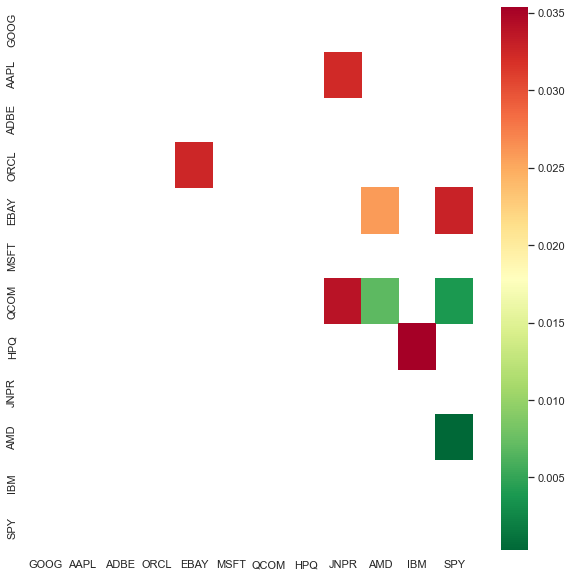

In [15]:
scores, pvalues, pairs = find_cointegrated_pairs(df)

fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r', mask=(pvalues>=0.05))

print(pairs)

Our Algorithm identified ('ADBE', 'MSFT'), ('EBAY', 'GOOG'), ('GOOG', 'ORCL'), ('GOOG', 'SPY'), ('IBM', 'MSFT'), ('IBM', 'ORCL'), ('IBM', 'SPY'), ('JNPR', 'QCOM'), ('ORCL', 'SPY'). 

We can further analyse their price patterns to make sure that there is nothing weird going on.

In [16]:
S1 = df['ADBE']
S2 = df['MSFT']

score, pvalue, _ = coint(S1, S2)
pvalue

0.03225389533753853

We can see that the pvalue <0.05, which means that ADBE and MSFT are indeed cointegrated pairs.

#### Calculating the Spread
Now we can plot the spread of the two time series. In order to actually calculate the spread, we use a linear regression to get the coefficient of the linear combination between ADBE and MSFT

In [17]:
S1 

Date
2013-01-02     38.340000
2013-01-03     37.750000
2013-01-04     38.130001
2013-01-07     37.939999
2013-01-08     38.139999
                 ...    
2020-12-24    499.859985
2020-12-28    498.950012
2020-12-29    502.109985
2020-12-30    497.450012
2020-12-31    500.119995
Name: ADBE, Length: 2015, dtype: float64

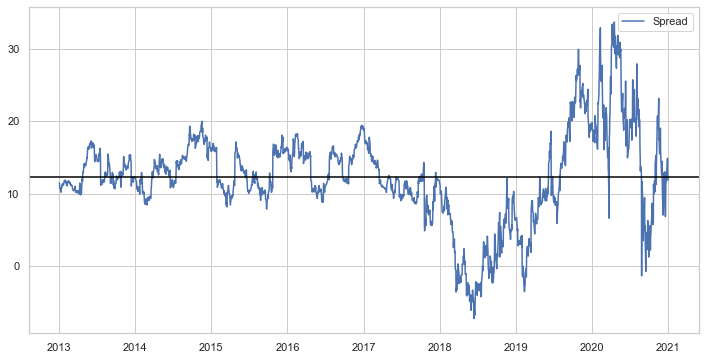

In [18]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2,S1).fit()
S1 = S1['ADBE']
b = results.params['ADBE']

spread = S2 - b * S1
plt.figure(figsize=(12,6))
plt.plot(spread)
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

Alternatively, we can examine the raio between the two time series.

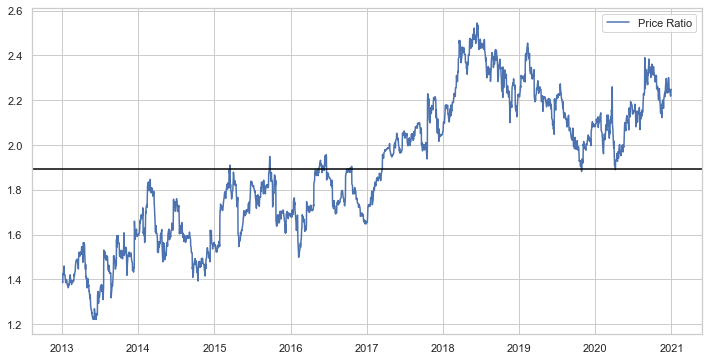

In [19]:
ratio = S1/S2
plt.figure(figsize=(12,6))
plt.plot(ratio)
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio'])

Regardless of whether or not we use the spread or ratio approach, we can see that our first plot pair, ADBE/MSFT tends to move around the mean. We now need to standardize this ratio because the absolute ration might not be the most ideal way of analyzing this trend.

For this, we need to use the z-scores.

A z-score is the number of standard deviations a datapoint is from the mean. More importantly, the number of standard deviations above or below the population mean is, from the raw score. The z-score is calculated by the following formula:
$$\mathcal{z}_{i}=\frac{x_{i}-\bar{x}}{s} $$

In [20]:
def z_score(series):
    return (series-series.mean()) / np.std(series)

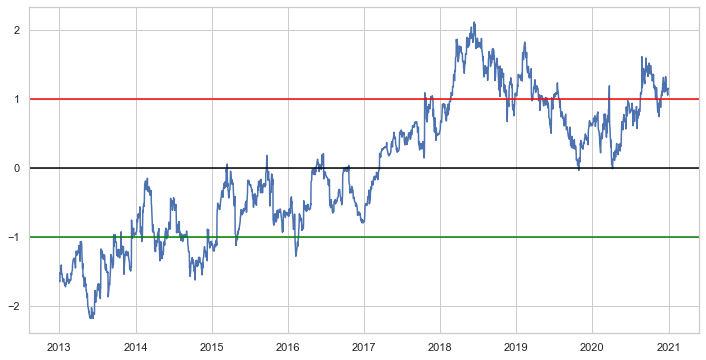

In [21]:
zscore_ratio = z_score(ratio)
plt.figure(figsize=(12,6))
plt.plot(zscore_ratio)
plt.axhline(1,0,color='red')
plt.axhline(-1,0,color='green')
plt.axhline(zscore_ratio.mean(),color='black')


By setting the two lines placed at the zscore of 1 and -1, we can clearly see that for most of the parts, any big divergences from the meab eventually converges back. This is exactly what we want for a pairs trading strategy.

### Trading Signals
When creating any type of trading strategies, it is always important to clearly define and delineate at what point do we actually want to place a trade. In otherwords, which is the best point to buy or sell a particular stock?

#### Setup Rules
We're going to use the ratio time series to see if it tells us whether to buy or sell at a particular moment in time. We'll start by creating a prediction variable Y. If the raio is positive, it will signal a "buy", otherwise, it will signal a sell. The prediction model is as follows:

$$Y_{t} = sign(Ratio_{t+1}-Ratio_{t}) $$

What's great about pair trading signals is that we don't need to know absolutes about where the prices will go, all we need to know is where it's heading: up or down.


#### Train Test Split

When training and testing a model, it's common to have splits of 70/30 or 80/20. We only used a time series of 252 points (which is the amount of trading days in a year). Before training and splitting the data, we will add more data points in each time series.

In [22]:
ratios = df['ADBE']/df['MSFT']
print(len(ratios)*0.7)

1410.5


In [23]:
train = ratios[:1411]
test = ratios[1411:]
print(len(train))
print(len(test))

1411
604


### Feature Engineering
We need to find out what features are actually important in determining the direction of the ratio moves. Knowing that the ratios always eventually revert back to the mean, maybe the moving averages and metrics related to the mean will be important.

We will use these features too:
* 60 Day Moving Average
* 5 Day Moving Average
* 60 Day Standard Deviation
* Z Score

Text(0, 0.5, 'Ratio')

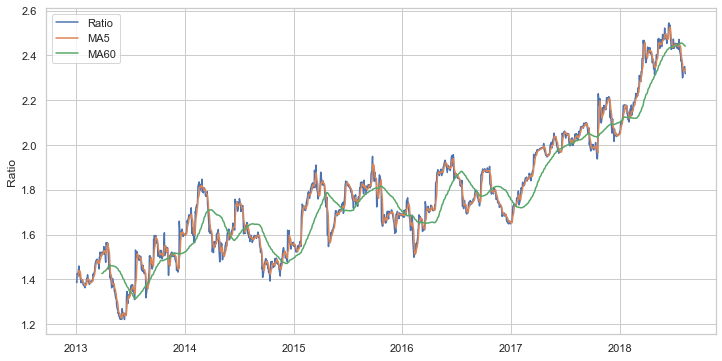

In [24]:
ratio_mavg_5 = train.rolling(window=5, center=False).mean()
ratio_mavg_60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
z_score_60_5 = (ratio_mavg_5 - ratio_mavg_60)/std_60

plt.figure(figsize=(12,6))
plt.plot(train)
plt.plot(ratio_mavg_5)
plt.plot(ratio_mavg_60)
plt.legend(['Ratio', 'MA5', 'MA60'])
plt.ylabel('Ratio')

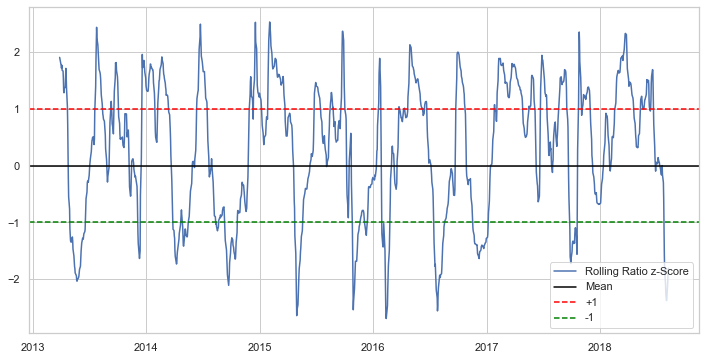

In [25]:
plt.figure(figsize=(12,6))
plt.plot(z_score_60_5)
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])

### Creating a Model
A standard normal distribution has a mean of 0 and a standard deviation of 1. Looking at the plot, we can tell quite clearly that if the time series 1 standard deviation beyond the mean, it tend to revert back towards the mean. Using these models, we can create teh following trade signals:
* Buy(1) whenever the z-score is below -1, meaning we expect the ratio to increase.
* Sell(1) whenever the z-score is above 1, meaning we expect the ratio to decrease.

### Training Optimization
We can use our model on actual data

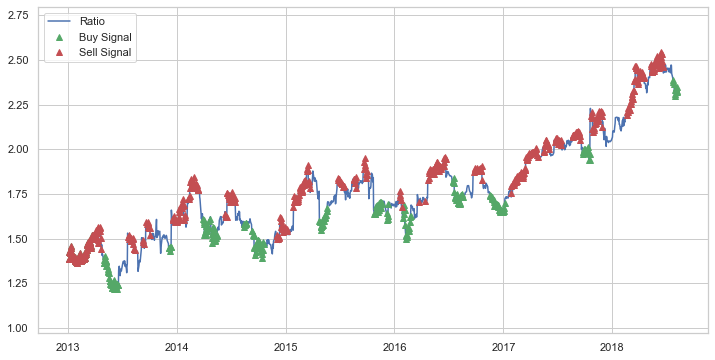

In [26]:
plt.figure(figsize=(12,6))
plt.plot(train)
buy = train.copy()
sell = train.copy()
# Remove all values in range of -1 and 1, not useful to trade!
buy[z_score_60_5>-1] = 0
sell[z_score_60_5<1] = 0
plt.plot(buy, color='g', marker='^', linestyle='None')
plt.plot(sell, color='r', marker='^', linestyle='None')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1, x2, ratios.min()-0.25, ratios.max()+0.25))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()


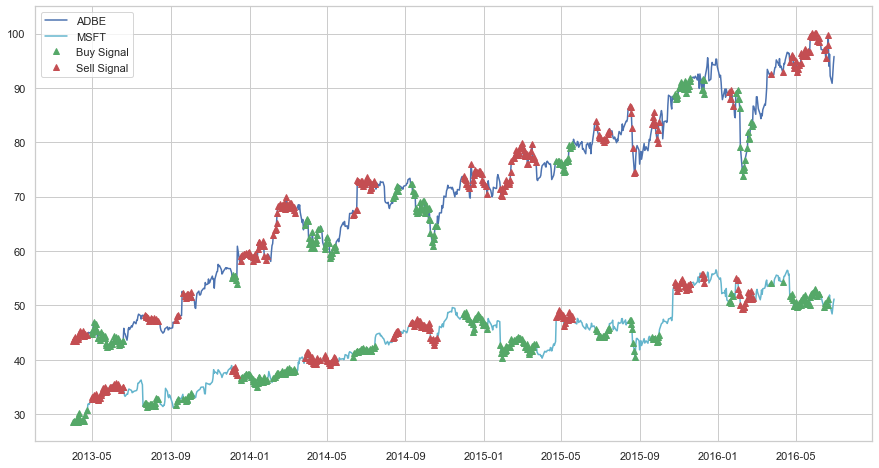

In [27]:
plt.figure(figsize=(15,8))
S1 = df['ADBE'].iloc[:881]
S2 = df['MSFT'].iloc[:881]

plt.plot(S1[60:],color='b')
plt.plot(S2[60:],color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

plt.plot(buyR[60:], color='g', linestyle='None', marker='^')
plt.plot(sellR[60:], color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 105)

plt.legend(['ADBE', 'MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

In [34]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    # If window is length 0, algorithm does not make sense, so exit
    if (window1==0) or (window2==0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate Trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    print(len(ratios))
    print(len(zscore))
    \

In [35]:
trade(df['ADBE'].iloc[881:], df['EBAY'].iloc[881:], 60, 5)

1134
1134


619.8740292756497

### Areas of Improvement and Further Steps

This is by no means a perfect strategy and the implementation of our strategy isn't the best. However, there are several things that can be improved upon.

#### 1. Using more securities and more varied time ranges

For the pairs trading strategy cointegration test, I only used a handful of stocks. Naturally (and in practice) it would be more effective to use clusters within an industry. I only use the time range of only 5 years, which may not be representative of stock market volatility.

#### 2. Dealing with overfitting

Anything related to data analysis and training models has much to do with the problem of overfitting. There are many different ways to deal with overfitting like validation, such as Kalman filters, and other statistical methods.

#### 3. Adjusting the trading signals

Our trading algorithm fails to account for stock prices that overlap and cross each other. Considering that the code only calls for a buy or sell given its ratio, it doesn't take into account which stock is actually higher or lower.

#### 4. More advanced methods

This is just the tip of the iceberg of what you can do with algorithmic pairs trading. It's simple because it only deals with moving averages and ratios. If you want to use more complicated statistics, feel free to do so. Other complex examples include subjects such as the Hurst exponent, half-life mean reversion, and Kalman Filters.